# Example 4: Calculate fault slip
This example describes how to correlate faults extracted at different time steps.

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-lj2zt83j
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-lj2zt83j
     |████████████████████████████████| 163kB 4.0MB/s 
     |████████████████████████████████| 103.4MB 90kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-z66wj49t/cv-algorithms
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-z66wj49t/cv-algorithms
  Created wheel for fatbox: filename=fatbox-0.0.1-cp37-none-any.whl size=25848 sha256=18a40c123d2a2ae73ae3186799638d5943080f55471cc453dfe7527138e10eca
  Stored in directory: /tmp/pip-ephem-wheel-cache-6h4kb_nn/wheels/3c/75/06/4f57a6a85e140ffdf1280b29ebde7d5e62277dfc68e4aeb466
  Created wheel for network: filename=network-0.1-cp37-none-any.whl size=3157 sha256=5db8017f271be0d0c63a61c0cbe593bc9d4f9cea8db4b6393d23efa8e58167cb
  Stored in directory: /root/.cache/pip/wheels/f6/e7/6a/7098

and get the tutorials:

In [2]:
!git clone https://github.com/thilowrona/fatbox_tutorials

Cloning into 'fatbox_tutorials'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 299 (delta 38), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (299/299), 30.34 MiB | 27.20 MiB/s, done.
Resolving deltas: 100% (109/109), done.


Now we can load the python packages:

In [3]:
import math
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from fatbox.metrics import total_length
from fatbox.plots import plot_faults, plot_components, plot_attribute

## Load and plot faults

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [4]:
G = pickle.load(open('/content/fatbox_tutorials/4-fault_slip/graphs/g_3.p', 'rb'))

Now we can visualize these faults:

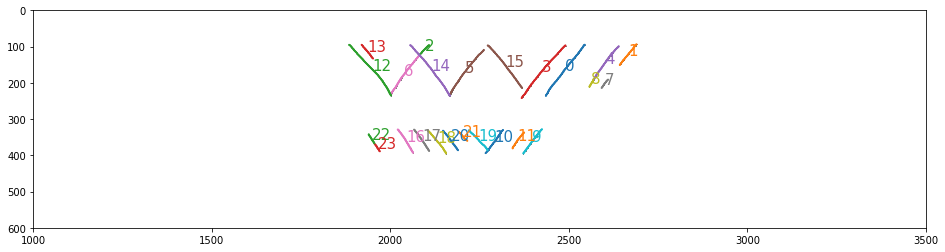

In [5]:
fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Load velocities in x- and z-direction:

In [6]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [7]:
!p7zip -d './fatbox_tutorials/4-fault_slip/velocity.7z'
!mv velocity.npy './fatbox_tutorials/4-fault_slip/'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./fatbox_tutorials/4-fault_slip/                                          1 file, 8961015 bytes (8751 KiB)

Extracting archive: ./fatbox_tutorials/4-fault_slip/velocity.7z
--
Path = ./fatbox_tutorials/4-fault_slip/velocity.7z
Type = 7z
Physical Size = 8961015
Headers Size = 130
Method = LZMA2:24
Solid = -
Blocks = 1

  0%     38% - velocity.npy                    67% - velocity.npy                    94% - velocity.npy                   Everything is Ok

Size:       43200128
Compressed: 8961015


In [8]:
data = np.load('./fatbox_tutorials/4-fault_slip/velocity.npy')

v_x  = data[:,:,0]
v_z  = data[:,:,1]

Visualize the velocity in z-direction:

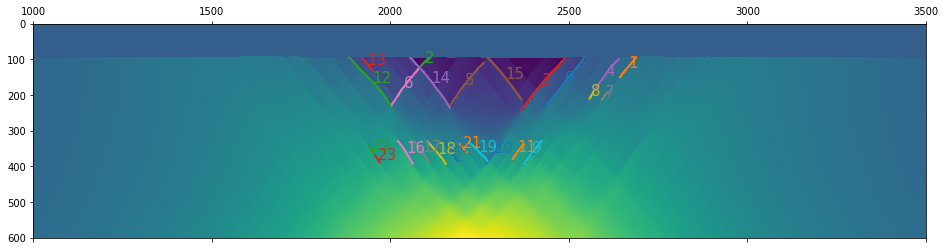

In [9]:
fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G, ax, label=True)
ax.matshow(v_z)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

## Extract velocities
Now we want to pick up the velocity left and right of each fault, but to do this we first need to calculate the direction of the fault:

In [10]:
def calculate_direction(G, cutoff, normalize=True):

    for node in G.nodes:            
        length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff)
        keys = [keys for keys,values in length.items() if values == max(length.values())]        
        if len(keys) >  2:
            (node_0, node_1) = keys[:2]
        if len(keys) == 2:
            (node_0, node_1) = keys
        if len(keys) == 1:
            node_0 = keys[0]
            
            length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff-1)
            keys = [keys for keys,values in length.items() if values == max(length.values())]
            
            node_1 = keys[0]

        # extrac position
        pt_0 = G.nodes[node_0]['pos']
        pt_1 = G.nodes[node_1]['pos']                  
        # calculate vector              
        dx = pt_0[0] - pt_1[0]
        dy = pt_0[1] - pt_1[1]            
        # write to graph
        G.nodes[node]['dx'] = dx
        G.nodes[node]['dy'] = dy   
             
    return G

G = calculate_direction(G, 3)

Now we use the direction to calculate the pick-up points:

In [11]:
def calculate_pickup_points(G, factor):

    H = nx.Graph() 
    
    for node in G.nodes:
        
        (x, y) = G.nodes[node]['pos']
        
        dx = G.nodes[node]['dx']
        dy = G.nodes[node]['dy']
        
        dx = factor * dx
        dy = factor * dy
    
        x_p = int(x - dy)
        y_p = int(y + dx)
    
        x_n = int(x + dy)
        y_n = int(y - dx)
    
        node_mid = (node, 0)
        H.add_node(node_mid)
        H.nodes[node_mid]['pos'] = (x, y)
        H.nodes[node_mid]['component']  = -1
    
        node_p = (node, 1)
        H.add_node(node_p)
        H.nodes[node_p]['pos'] = (x_p, y_p)
        H.nodes[node_p]['component']  = -2
    
        node_n = (node, 2)
        H.add_node(node_n)
        H.nodes[node_n]['pos'] = (x_n, y_n)
        H.nodes[node_n]['component']  = -3
    
    
        H.add_edge(node_n, node_p)
                
    return H

H = calculate_pickup_points(G, 1)

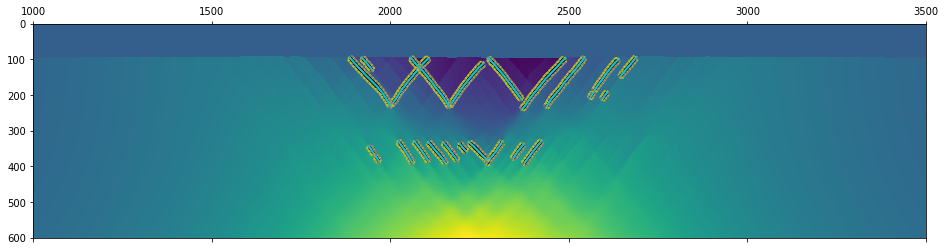

In [12]:
fig, ax = plt.subplots(figsize=(16,4))
plot_components(H, ax, label=False)
ax.matshow(v_z)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

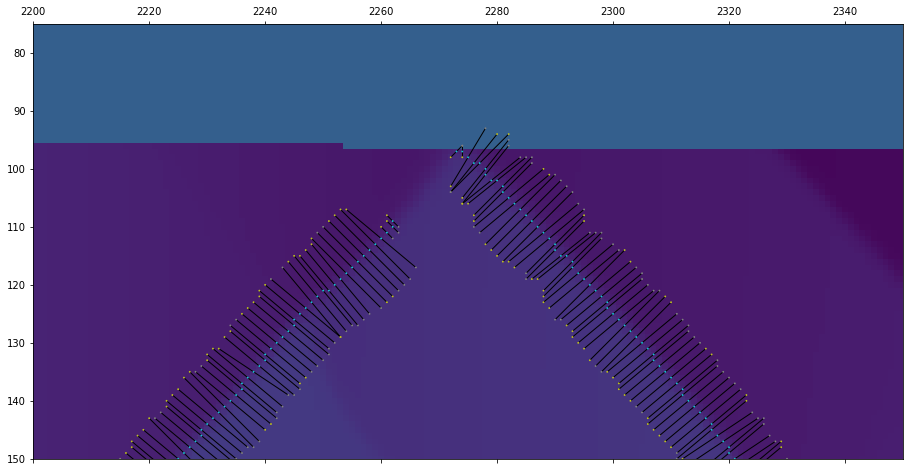

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
plot_components(H, ax, label=False)
ax.matshow(v_z)
plt.xlim([2200, 2350])
plt.ylim([150, 75])
plt.show()

In [14]:
def extract_attribute(G, image, name):
    (x_max, y_max) = image.shape   
    for node in G:
        y,x = G.nodes[node]['pos']
        if x >= x_max or y>=y_max:
            G.nodes[node][name] = float('nan')        
        else:
            G.nodes[node][name] = image[int(x),int(y)]
    return G

H = extract_attribute(H, v_x, 'v_x')
H = extract_attribute(H, v_z, 'v_z')

In [15]:
def filter_pickup_points(G, H):    
    for node in G:      
        if H.nodes[(node, 1)]['pos'][1] < 0 or H.nodes[(node, 2)]['pos'][1] < 0:
            
            H.nodes[(node,0)]['v_x'] = 0
            H.nodes[(node,0)]['v_z'] = 0
    
            H.nodes[(node,1)]['v_x'] = 0
            H.nodes[(node,1)]['v_z'] = 0
    
            H.nodes[(node,2)]['v_x'] = 0
            H.nodes[(node,2)]['v_z'] = 0

    return H

H = filter_pickup_points(G, H)

## Compute slip and slip rate

In [16]:
def calculate_slip_rate(G, H, dim):
    if dim == 2:
        for node in H.nodes:
            if node[1] == 0:    # centre point
            
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_rate_x'] =  0
                    G.nodes[node[0]]['slip_rate_z'] =  0
                    G.nodes[node[0]]['slip_rate']   =  0
                else:            
                    G.nodes[node[0]]['slip_rate_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))
                    G.nodes[node[0]]['slip_rate_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))
                    G.nodes[node[0]]['slip_rate']   =  math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + G.nodes[node[0]]['slip_rate_z']**2)
    if dim == 3:
        for node in H.nodes:
            if node[1] == 0:    # centre point   
                # Outside of the box
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_rate_x'] =  0
                    G.nodes[node[0]]['slip_rate_y'] =  0
                    G.nodes[node[0]]['slip_rate_z'] =  0
                    G.nodes[node[0]]['slip_rate']   =  0        
                # Inside the box
                else:            
                    G.nodes[node[0]]['slip_rate_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))
                    G.nodes[node[0]]['slip_rate_y'] =  abs((H.nodes[(node[0], 1)]['v_y'] - H.nodes[(node[0], 2)]['v_y']))
                    G.nodes[node[0]]['slip_rate_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))
                    G.nodes[node[0]]['slip_rate']   =  math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + 
                                                                 G.nodes[node[0]]['slip_rate_y']**2 + 
                                                                 G.nodes[node[0]]['slip_rate_z']**2)        
        
    return G

G = calculate_slip_rate(G, H, dim=2)

In [17]:
def calculate_slip(G, H, dt, dim):
    if dim == 2:
        for node in H.nodes:
            if node[1] == 0:
                
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_x'] =  0
                    G.nodes[node[0]]['slip_z'] =  0
                    G.nodes[node[0]]['slip']   =  0
                else:            
                    G.nodes[node[0]]['slip_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))*dt
                    G.nodes[node[0]]['slip_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))*dt
                    G.nodes[node[0]]['slip']   =  math.sqrt(G.nodes[node[0]]['slip_x']**2 + G.nodes[node[0]]['slip_z']**2)
                                                            
    if dim == 3:
        for node in H.nodes:
            if node[1] == 0:
                
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_x'] =  0
                    G.nodes[node[0]]['slip_y'] =  0
                    G.nodes[node[0]]['slip_z'] =  0
                    G.nodes[node[0]]['slip']   =  0
                else:            
                    G.nodes[node[0]]['slip_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))*dt
                    G.nodes[node[0]]['slip_y'] =  abs((H.nodes[(node[0], 1)]['v_y'] - H.nodes[(node[0], 2)]['v_y']))*dt
                    G.nodes[node[0]]['slip_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))*dt
                    G.nodes[node[0]]['slip']   =  math.sqrt(G.nodes[node[0]]['slip_x']**2 + 
                                                            G.nodes[node[0]]['slip_y']**2 + 
                                                            G.nodes[node[0]]['slip_z']**2)
    return G

G = calculate_slip(G, H, dim=2, dt=94804)

## Visualization


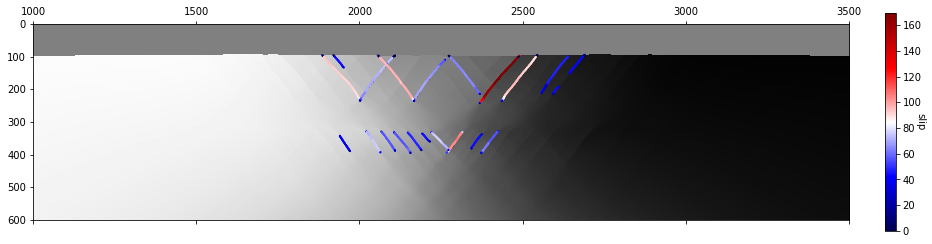

In [18]:
fig, ax = plt.subplots(figsize=(16,4))
plot_attribute(G, 'slip', ax)
ax.matshow(v_x, cmap='gray')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

In [19]:
def get_fault_labels(G):
    labels=set()
    for node in G:
        labels.add(G.nodes[node]['fault'])
    return sorted(list(labels))

def get_fault(G, n):
    nodes = [node for node in G if G.nodes[node]['fault']==n]
    return G.subgraph(nodes)


labels = get_fault_labels(G)

lengths = []
slips   = []
for label in labels:
    fault = get_fault(G, label)
    lengths.append(total_length(fault))
    slips.append(np.max([fault.nodes[node]['slip'] for node in fault]))


In [20]:
G.nodes[10]

{'component': 0,
 'dx': -5,
 'dy': 6,
 'edges': 2,
 'fault': 0,
 'polarity': 0,
 'pos': (2538, 104),
 'slip': 90.22910443105594,
 'slip_rate': 0.0009517436440556932,
 'slip_rate_x': 0.0005521000000000002,
 'slip_rate_z': 0.0007752429,
 'slip_x': 52.341288400000025,
 'slip_z': 73.4961278916}

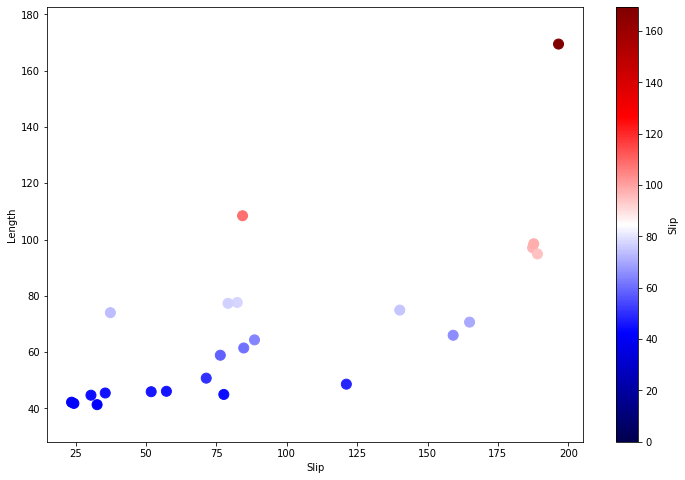

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(lengths, slips, c=slips, s=100, cmap='seismic', vmin=0)
plt.xlabel('Slip')
plt.ylabel('Length')
plt.axis('equal')
cbar=plt.colorbar()
cbar.set_label('Slip')
plt.show()